In [3]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/5_policy_gradient-reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import discount_cumsum, run_experiment_episode_train, DeepAgent

### Run locally

In [5]:
from rl_introduction.tools import discount_cumsum, run_experiment_episode_train, DeepAgent

### Objective
Here we present an alternative of Q learning: policy gradient algorithm

# Policy gradient
In policy gradient, we parametrize directly the policy $\pi_\theta$. It's especially welcome when the action space is continuous; in that case greedy policy based on Q-learning need to compute the $argmax_a Q(s,a)$. This could be pretty tedious. More generally, policy gradient algorithms are better to explore large state-action spaces.

$J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}[{G(\tau)}]$

We can proof  that:


$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) G(\tau)}]$ 

1. In discrete action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow [0,1]^{dim(A)}$ and $\forall s$ $\sum \pi_\theta(s) = 1$.


2. In continous action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow \mu^{dim(A)} \times \sigma^{dim(A)} =  \mathbb{R}^{dim(A)} \times \mathbb{R}_{+,*}^{dim(A)}$



In keras, it is easier to pass the loss than the gradient.
1. It is possible to show that the loss for discrete action ($1,...,N$) with softmax policy is weighted negative binary crossentropy:
$-G\sum_{j=1}^N[a^j\log(\hat{a}^j) + (1-a^j)\log(1 - \hat{a}^j)]$

with:
$a^j=1$ if $a_t = j$, $0$ otherwise.

$\hat{a}^j = \pi_\theta(s_t)^j$.

$G$ is the discounted empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$ from state $s_t$ and $a_t$


2. It is possible to show that the loss for conitnous action ($1,...,N$) with multivariate Gaussian (identity Covariance) policy is given by:

$-G\sum_{j=1}^N[(a^j - \hat{a}^j)^2]$

$\hat{a}^j = \pi_\theta(s_t)^j$.



see https://aleksispi.github.io/assets/pg_autodiff.pdf for more explanation

# Reinforce - discrete action

In [6]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf

### TODO 1): write custom loss for policy gradient

In [7]:
#TODO: write custom loss for policy gradient
def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = None #to complete
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [8]:
#Done: write custom loss for policy gradient
def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [13]:
# Example of our parametrize policy function discrete action space
def build_model(state_sim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    x = Dense(32, activation='relu')(input_state)
    x = Dense(32, activation='relu')(x)
    x = Dense(action_dim, activation='softmax')(x)
    model = Model(inputs=input_state, outputs=x)
    return model

### TODO 2): complete training of vanilla policy gradient

In [14]:
#TODO: complete training of vanilla policy gradient
# 
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01):
        super().__init__(env,gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.episode = []

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward])) # save the trajectory
        if done is True: # Compute and use the discouted_reward at the end of the episode and train
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            pass # complete here
            # Compute the custom loss
            # train

    def save_model(self, path):
        self.model.save(path)

In [11]:
#Done: complete training of vanilla policy gradient
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01):
        super().__init__(env,gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.episode = []

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            states = np.vstack(episode[:,0])
            actions = np.zeros((len(episode), self.action_dim))
            actions[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            loss = policy_gradient_loss(discounted_return)
            self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-3))
            self.model.train_on_batch(states,actions)
            self.episode = []

    def save_model(self, path):
        self.model.save(path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_state (InputLayer)    [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


2022-03-22 18:02:05.195712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/raphael/rl_introduction/venv/lib/python3.7/site-packages/cv2/../../lib64::/home/raphael/.mujoco/mjpro150/bin
2022-03-22 18:02:05.195749: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 18:02:05.195769: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (raphael-XPS-13-9370): /proc/driver/nvidia/version does not exist
2022-03-22 18:02:05.195981: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

episode: 0 - cum reward 25.0
episode: 1 - cum reward 20.0
episode: 2 - cum reward 11.0
episode: 3 - cum reward 13.0
episode: 4 - cum reward 18.0
episode: 5 - cum reward 43.0
episode: 6 - cum reward 16.0
episode: 7 - cum reward 10.0
episode: 8 - cum reward 86.0
episode: 9 - cum reward 8.0
episode: 10 - cum reward 12.0
episode: 11 - cum reward 40.0
episode: 12 - cum reward 24.0
episode: 13 - cum reward 46.0
episode: 14 - cum reward 10.0
episode: 15 - cum reward 13.0
episode: 16 - cum reward 24.0
episode: 17 - cum reward 26.0
episode: 18 - cum reward 12.0
episode: 19 - cum reward 15.0
episode: 20 - cum reward 13.0
episode: 21 - cum reward 15.0
episode: 22 - cum reward 18.0
episode: 23 - cum reward 14.0
episode: 24 - cum reward 32.0
episode: 25 - cum reward 44.0
episode: 26 - cum reward 17.0
episode: 27 - cum reward 39.0
episode: 28 - cum reward 53.0
episode: 29 - cum reward 21.0
episode: 30 - cum reward 14.0
episode: 31 - cum reward 22.0
episode: 32 - cum reward 41.0
episode: 33 - cum rew

episode: 221 - cum reward 33.0
episode: 222 - cum reward 25.0
episode: 223 - cum reward 12.0
episode: 224 - cum reward 39.0
episode: 225 - cum reward 46.0
episode: 226 - cum reward 37.0
episode: 227 - cum reward 23.0
episode: 228 - cum reward 35.0
episode: 229 - cum reward 69.0
episode: 230 - cum reward 31.0
episode: 231 - cum reward 43.0
episode: 232 - cum reward 100.0
episode: 233 - cum reward 30.0
episode: 234 - cum reward 24.0
episode: 235 - cum reward 65.0
episode: 236 - cum reward 40.0
episode: 237 - cum reward 49.0
episode: 238 - cum reward 16.0
episode: 239 - cum reward 26.0
episode: 240 - cum reward 13.0
episode: 241 - cum reward 54.0
episode: 242 - cum reward 36.0
episode: 243 - cum reward 42.0
episode: 244 - cum reward 59.0
episode: 245 - cum reward 31.0
episode: 246 - cum reward 48.0
episode: 247 - cum reward 30.0
episode: 248 - cum reward 39.0
episode: 249 - cum reward 16.0
episode: 250 - cum reward 39.0
episode: 251 - cum reward 50.0
episode: 252 - cum reward 36.0
episode

Text(0.5, 1.0, 'cumulative reward per episode - vpg_agent')

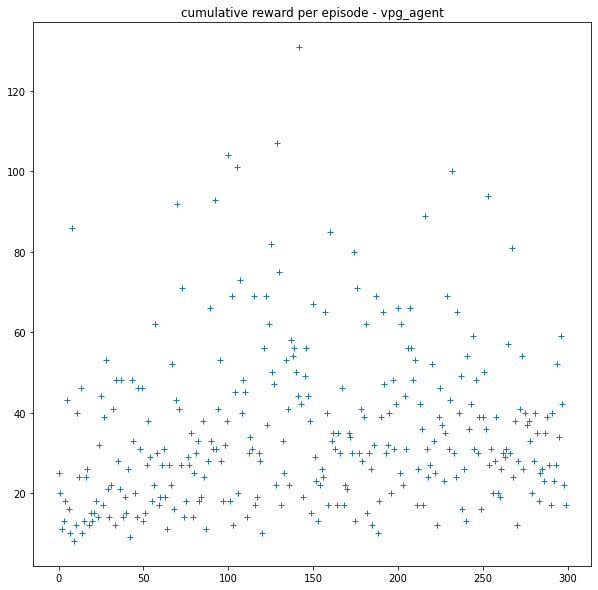

In [12]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)
r_agent = ReinforceAgent(env, model)
rewards = run_experiment_episode_train(env, r_agent, 300)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - vpg_agent')

### TODO 3) : Try different hyerparamters models (number of layers, nodes) and compare learning

In [15]:
# Example of our parametrize policy function discrete action space
def your_build_model(state_sim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    x = Dense(1, activation='relu')(input_state)
    x = Dense(1, activation='relu')(x)
    x = Dense(action_dim, activation='softmax')(x)
    model = Model(inputs=input_state, outputs=x)
    return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_state (InputLayer)    [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
 dense_8 (Dense)             (None, 2)                 4         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 16.0
episode: 1 - cum reward 18.0
episode: 2 - cum reward 19.0
episode: 3 - cum reward 36.0
episode: 4 - cum reward 19.0
episode: 5 - cum reward 20.0
episode: 6 - cum rewa

episode: 238 - cum reward 31.0
episode: 239 - cum reward 39.0
episode: 240 - cum reward 28.0
episode: 241 - cum reward 23.0
episode: 242 - cum reward 20.0
episode: 243 - cum reward 12.0
episode: 244 - cum reward 19.0
episode: 245 - cum reward 28.0
episode: 246 - cum reward 23.0
episode: 247 - cum reward 23.0
episode: 248 - cum reward 11.0
episode: 249 - cum reward 37.0
episode: 250 - cum reward 20.0
episode: 251 - cum reward 27.0
episode: 252 - cum reward 11.0
episode: 253 - cum reward 14.0
episode: 254 - cum reward 16.0
episode: 255 - cum reward 18.0
episode: 256 - cum reward 15.0
episode: 257 - cum reward 15.0
episode: 258 - cum reward 31.0
episode: 259 - cum reward 14.0
episode: 260 - cum reward 17.0
episode: 261 - cum reward 59.0
episode: 262 - cum reward 24.0
episode: 263 - cum reward 14.0
episode: 264 - cum reward 17.0
episode: 265 - cum reward 14.0
episode: 266 - cum reward 14.0
episode: 267 - cum reward 32.0
episode: 268 - cum reward 24.0
episode: 269 - cum reward 22.0
episode:

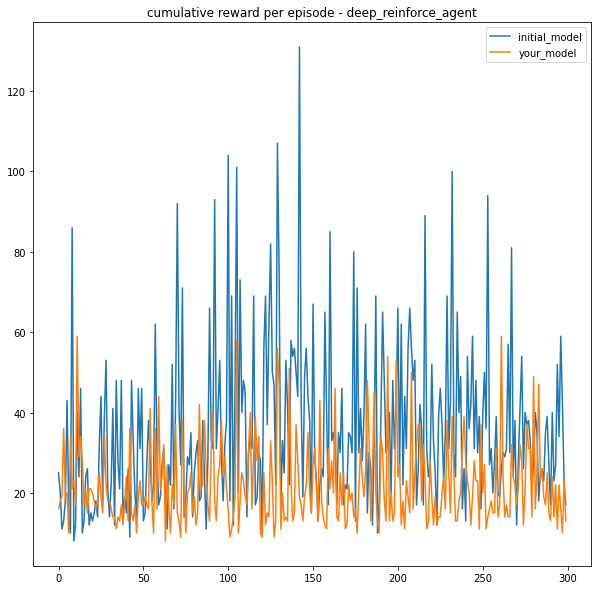

In [17]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
your_model = your_build_model(state_dim, action_dim)
your_r_agent = ReinforceAgent(env, your_model)
your_rewards = run_experiment_episode_train(env, your_r_agent, 300)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,label='initial_model')
ax.plot(your_rewards,label='your_model')
ax.set_title('cumulative reward per episode - deep_reinforce_agent')
ax.legend()

# Reinforce with memory - discrete action

In opposite as Q learning, policy optimization is an on-policy algorithm, so we are training directly on the policy output and we need to compute them first.

In [19]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgentWithMemory(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01, memory_size = 3):
        super().__init__(env,  gamma, epsilon)
        
        self.model = compiled_model
        
        self.model.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        
    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            Y[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                discounted_returns -= discounted_returns.mean()
                discounted_returns /= discounted_returns.std()
                self.episodes = []
                loss = policy_gradient_loss(discounted_returns)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
            else:
                self.episodes.append([X,Y,discounted_return])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_state (InputLayer)    [(None, 4)]               0         
                                                                 
 dense_9 (Dense)             (None, 32)                160       
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 37.0
episode: 1 - cum reward 52.0
episode: 2 - cum reward 12.0
episode: 3 - cum reward 16.0
episode: 4 - cum reward 47.0
episode: 5 - cum reward 52.0
episode: 6 - cu

episode: 235 - cum reward 51.0
episode: 236 - cum reward 93.0
episode: 237 - cum reward 116.0
episode: 238 - cum reward 156.0
episode: 239 - cum reward 124.0
episode: 240 - cum reward 200.0
episode: 241 - cum reward 200.0
episode: 242 - cum reward 200.0
episode: 243 - cum reward 200.0
episode: 244 - cum reward 111.0
episode: 245 - cum reward 134.0
episode: 246 - cum reward 127.0
episode: 247 - cum reward 92.0
episode: 248 - cum reward 169.0
episode: 249 - cum reward 179.0
episode: 250 - cum reward 168.0
episode: 251 - cum reward 144.0
episode: 252 - cum reward 200.0
episode: 253 - cum reward 200.0
episode: 254 - cum reward 200.0
episode: 255 - cum reward 51.0
episode: 256 - cum reward 195.0
episode: 257 - cum reward 161.0
episode: 258 - cum reward 28.0
episode: 259 - cum reward 136.0
episode: 260 - cum reward 200.0
episode: 261 - cum reward 200.0
episode: 262 - cum reward 200.0
episode: 263 - cum reward 200.0
episode: 264 - cum reward 197.0
episode: 265 - cum reward 200.0
episode: 266 

Text(0.5, 1.0, 'cumulative reward per episode - vpg_agent large memory')

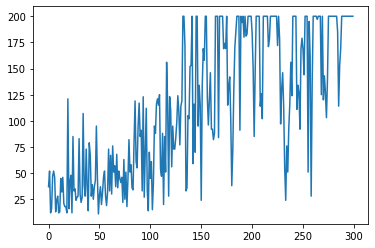

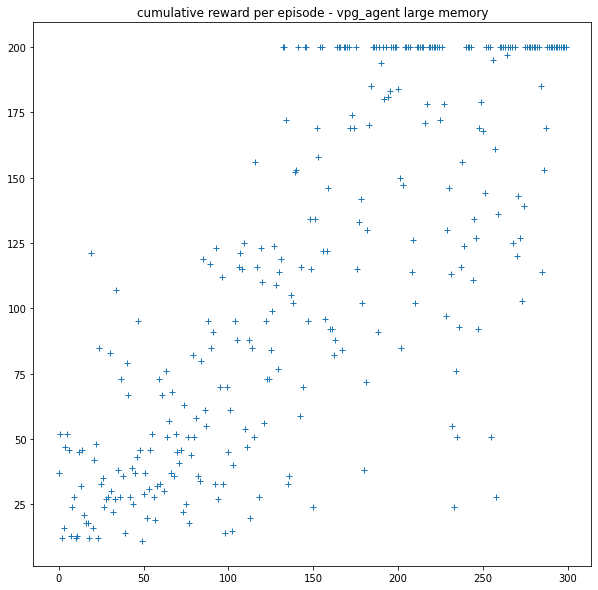

In [20]:
env = gym.make('CartPole-v0')
model = build_model(state_dim, action_dim)
q_agent = ReinforceAgentWithMemory(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - vpg_agent large memory')

# other improvements 

### GAE(general advantage estimation) actor critic
We can rewrite the policy gradient

$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \Phi_t}]$,

whith $\Phi_t$ could be any of:
- $\Phi_t =  G_t$
- $\Phi_t = \sum_{t'=t}^T R_{t+1} - V(s_t)$
- $\Phi_t = \sum_{t'=t}^T R_{t+1} - Q(s_t,a_t)$


For the last 2 cases we need to estimate V or Q (the critics). We do it as the same way at deepQ.
https://arxiv.org/pdf/1506.02438.pdf

$\phi_k = \arg \min_{\phi} E_{s_t, G_t \sim \pi_k}[{\left( V_{\phi}(s_t) - G_t \right)^2}]$

### off policy
To build an experience replay for policy gradient, it is necessary to unbias the experiences.
https://arxiv.org/pdf/1205.4839.pdf

### clipping